# Introduction to Object Detection with Deep Learning

This notebook introduces **object detection**, the task of locating and classifying multiple objects within an image.

## The Computer Vision Task Hierarchy

| Task | Input | Output | Example |
|------|-------|--------|---------|
| **Classification** | Image | Single label | "This image contains apples" |
| **Segmentation** | Image | Pixel mask | Exact apple boundaries |
| **Detection** | Image | Bounding boxes + labels | Rectangles around each apple with class labels |

### What Makes Detection Unique?

Detection combines **localization** (where?) with **classification** (what?):
- **Multiple objects** per image (variable number)
- **Bounding boxes**: 4 coordinates $(x_{min}, y_{min}, x_{max}, y_{max})$
- **Class labels**: What object is in each box
- **Confidence scores**: How sure the model is

## Key Detection Concepts

### 1. Bounding Boxes
A bounding box is defined by 4 values:
- **XYXY format**: $(x_{min}, y_{min}, x_{max}, y_{max})$ - corners
- **XYWH format**: $(x_{center}, y_{center}, width, height)$ - center + size
- **Normalized**: Values in $[0, 1]$ relative to image size

### 2. Intersection over Union (IoU)
Measures overlap between predicted and ground truth boxes:

$$\text{IoU} = \frac{\text{Area of Intersection}}{\text{Area of Union}}$$

- IoU = 1.0: Perfect match
- IoU > 0.5: Typically considered a "correct" detection
- IoU = 0: No overlap

### 3. Non-Maximum Suppression (NMS)
Detectors often predict multiple overlapping boxes for the same object. NMS keeps only the best:
1. Sort boxes by confidence score
2. Keep the highest scoring box
3. Remove all boxes with IoU > threshold with the kept box
4. Repeat for remaining boxes

### 4. Confidence Threshold
Filter out low-confidence predictions (typically keep predictions with confidence > 0.5)

---

## Setup and Dependencies

In [ ]:
# Install required packages
# ultralytics provides YOLOv8 - a state-of-the-art detection model
%pip install torch torchvision ultralytics tqdm matplotlib numpy pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.6 MB/s eta 0:00:00


### Download the Apple Detection Dataset

We'll use the **MinneApple** dataset - apple detection in orchards. This is a real-world agricultural application of object detection.

In [ ]:
!curl -L -o detection.tar.gz "https://conservancy.umn.edu/server/api/core/bitstreams/3ef26f04-6467-469b-9857-f443ffa1bb61/content"
!tar -xvzf detection.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1740M    0 1740M    0     0  3590k      0 --:--:--  0:08:16 --:--:-- 2974k
detection/test/images/dataset2_back_630.png
detection/train/masks/20150919_174151_image11.png
detection/train/images/20150919_174730_image161.png
detection/train/masks/20150921_131346_image1121.png
detection/train/masks/20150921_131234_image546.png
detection/test/images/dataset3_front_510.png
detection/train/images/20150921_131346_image1121.png
detection/train/images/
detection/train/masks/20150921_132245_image396.png
detection/train/masks/20150921_131453_image676.png
detection/train/masks/20150921_131833_image296.png
detection/train/images/20150919_174151_image301.png
detection/train/images/20150921_132038_image76.png
detection/train/masks/20150921_131453_image1196.png
detection/train/images/20150921_131346_image51.png
detection/train/masks/20150921_13

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import random
import shutil
import yaml

# Torchvision
from torchvision import tv_tensors
from torchvision.transforms import v2

# Ultralytics YOLO
from ultralytics import YOLO

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == "cpu":
    device = torch.device('mps') if torch.backends.mps.is_available() and torch.backends.mps.is_built() else device
print(f'Using device: {device}')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda


---

## YOLO: You Only Look Once

**YOLO** is a family of real-time object detection models known for speed and accuracy.

### Why YOLO?

| Approach | Method | Speed | Accuracy |
|----------|--------|-------|----------|
| **Two-stage** (R-CNN, Faster R-CNN) | 1. Propose regions → 2. Classify | Slow | High |
| **One-stage** (YOLO, SSD) | Single pass through network | Fast | Good |

### YOLO Architecture Overview

```
Input Image (640×640)
       │
       ▼
┌─────────────────────────────────────────────────┐
│              BACKBONE (Feature Extraction)       │
│  CSPDarknet / EfficientNet / etc.               │
│  Extracts hierarchical features at multiple     │
│  scales (small, medium, large objects)          │
└─────────────────────────────────────────────────┘
       │
       ▼
┌─────────────────────────────────────────────────┐
│              NECK (Feature Fusion)               │
│  FPN (Feature Pyramid Network) + PAN            │
│  Combines features from different scales        │
└─────────────────────────────────────────────────┘
       │
       ▼
┌─────────────────────────────────────────────────┐
│              HEAD (Detection)                    │
│  Predicts for each grid cell:                   │
│  - Bounding box coordinates (x, y, w, h)        │
│  - Objectness score (is there an object?)       │
│  - Class probabilities                          │
└─────────────────────────────────────────────────┘
       │
       ▼
   Predictions + NMS → Final Detections
```

### YOLOv8 Model Sizes

We'll use **YOLOv8n** (nano) - the smallest and fastest variant:

| Model | Size | Parameters | Speed | mAP |
|-------|------|------------|-------|-----|
| YOLOv8n | Nano | 3.2M | Fastest | Good |
| YOLOv8s | Small | 11.2M | Fast | Better |
| YOLOv8m | Medium | 25.9M | Medium | High |
| YOLOv8l | Large | 43.7M | Slower | Higher |
| YOLOv8x | XLarge | 68.2M | Slowest | Highest |

---

## Dataset Preparation

### The Apple Dataset Structure

The dataset contains:
- **Images**: RGB photos of apple trees
- **Masks**: Instance segmentation masks (each apple has unique color)

We'll convert masks to YOLO format bounding boxes.

In [ ]:
class AppleDataset(object):
    def __init__(self, root_dir, transforms):
        self.root_dir = root_dir
        self.transforms = transforms

        # Load all image and mask files, sorting them to ensure they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root_dir, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root_dir, "masks"))))

    def __getitem__(self, idx):
        # Load images and masks
        img_path = os.path.join(self.root_dir, "images", self.imgs[idx])
        mask_path = os.path.join(self.root_dir, "masks", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)     # Each color of mask corresponds to a different instance with 0 being the background

        # Convert the PIL image to np array
        mask = np.array(mask)
        obj_ids = np.unique(mask)

        # Remove background id
        obj_ids = obj_ids[1:]

        # Split the color-encoded masks into a set of binary masks
        masks = mask == obj_ids[:, None, None]

        # Get bbox coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        valid_mask_indices = []  # Track which masks are valid
        h, w = mask.shape
        for ii in range(num_objs):
            pos = np.where(masks[ii])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])

            if xmin == xmax or ymin == ymax:
                continue

            xmin = np.clip(xmin, a_min=0, a_max=w)
            xmax = np.clip(xmax, a_min=0, a_max=w)
            ymin = np.clip(ymin, a_min=0, a_max=h)
            ymax = np.clip(ymax, a_min=0, a_max=h)
            boxes.append([xmin, ymin, xmax, ymax])
            valid_mask_indices.append(ii)

        # Convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Keep only valid masks
        masks = masks[valid_mask_indices]

        # Use actual number of valid boxes (not num_objs)
        num_valid = len(boxes)
        labels = torch.ones((num_valid,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if num_valid > 0 else torch.zeros(0)

        # All instances are not crowd
        iscrowd = torch.zeros((num_valid,), dtype=torch.int64)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=(h, w))
        target["labels"] = labels
        target["masks"] = tv_tensors.Mask(masks)
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

    def get_img_name(self, idx):
        return self.imgs[idx]

### Dataset Class

This class extracts bounding boxes from instance segmentation masks:
1. Load image and mask
2. Find unique object IDs in mask (each apple has different color)
3. For each object, compute bounding box from mask coordinates

In [ ]:
# Simple transform for visualization (no augmentation)
transform = v2.Compose([
    v2.ToImage(),
])

ds = AppleDataset(root_dir="detection/train", transforms=transform)
print(f"Dataset size: {len(ds)} images")

Dataset size: 670 images


---

## Data Visualization

Let's visualize some images with their ground truth bounding boxes. This helps us understand:
- The density of objects per image
- Object sizes and aspect ratios
- Image quality and characteristics

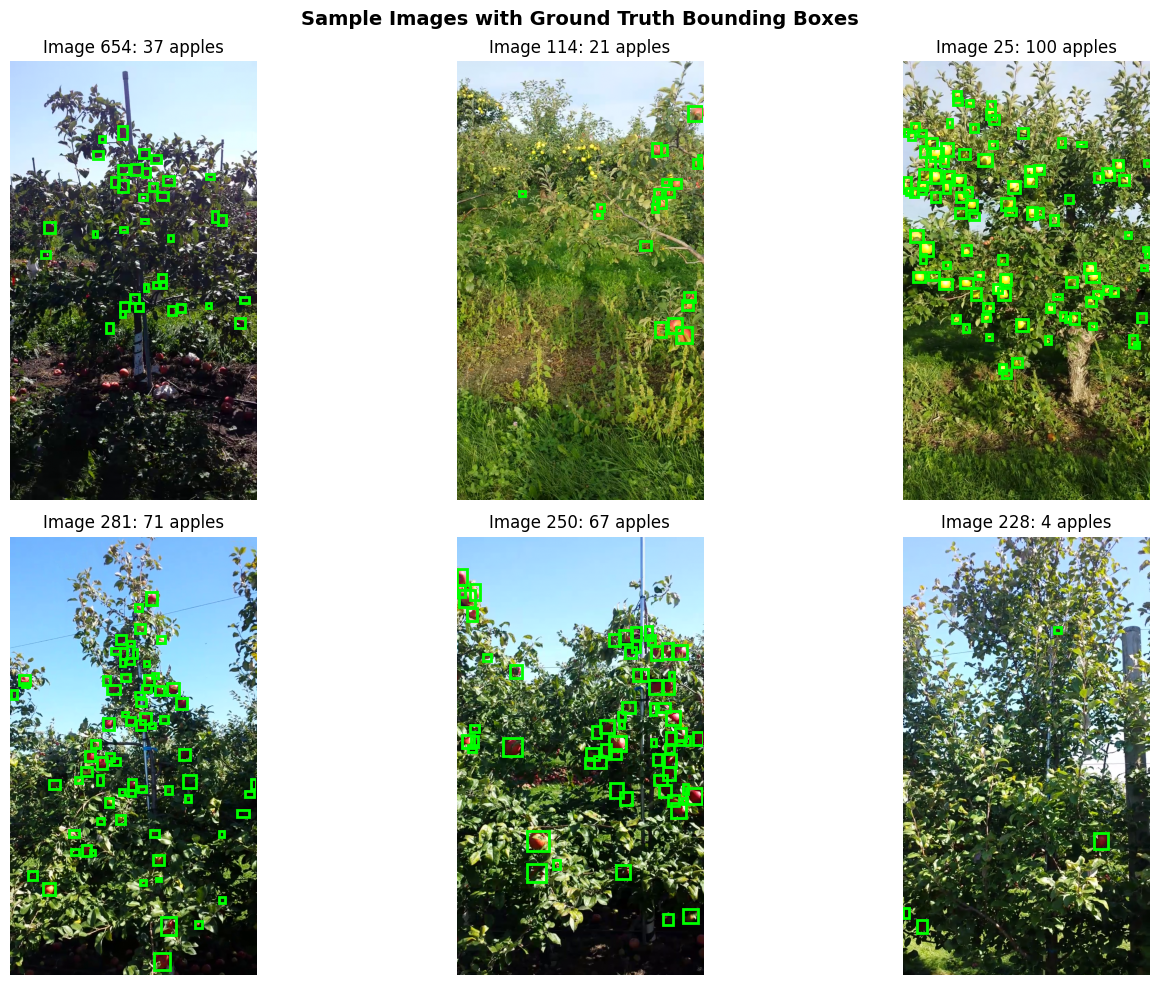

In [ ]:
def plot_image_with_boxes(img, boxes, ax, title="", color='lime', linewidth=2):
    """Plot image with bounding boxes overlay."""
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).cpu().numpy()
    if img.max() > 1:
        img = img / 255.0

    ax.imshow(img)
    for box in boxes:
        xmin, ymin, xmax, ymax = box[:4]
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle(
            (xmin, ymin), width, height,
            linewidth=linewidth, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_title(title)
    ax.axis('off')

# Visualize random samples
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

indices = random.sample(range(len(ds)), 6)

for i, idx in enumerate(indices):
    img, target = ds[idx]
    boxes = target["boxes"]
    n_objects = len(boxes)
    plot_image_with_boxes(img, boxes, axs[i], title=f"Image {idx}: {n_objects} apples")

plt.suptitle("Sample Images with Ground Truth Bounding Boxes", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Dataset Statistics

Let's analyze the distribution of objects per image and bounding box sizes.

Analyzing dataset: 100%|██████████| 670/670 [02:20<00:00,  4.79it/s]


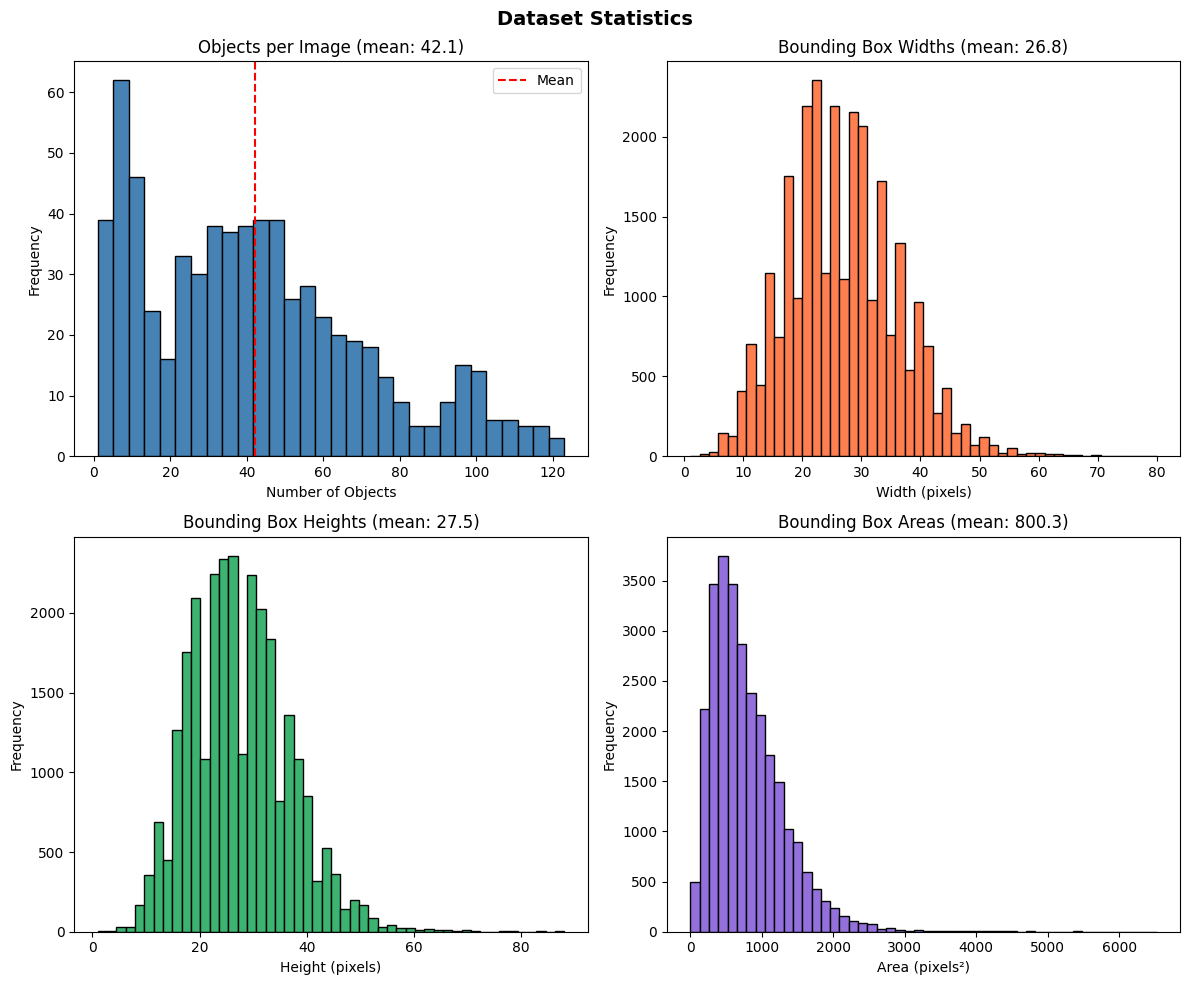


📊 Dataset Summary:
   Total images: 670
   Total objects: 28182
   Objects per image: 42.1 ± 29.0
   Average box size: 26.8 × 27.5 pixels


In [ ]:
# Collect statistics
objects_per_image = []
box_widths = []
box_heights = []
box_areas = []

for idx in tqdm(range(len(ds)), desc="Analyzing dataset"):
    _, target = ds[idx]
    boxes = target["boxes"]
    objects_per_image.append(len(boxes))

    for box in boxes:
        xmin, ymin, xmax, ymax = box[:4]
        w = float(xmax - xmin)
        h = float(ymax - ymin)
        box_widths.append(w)
        box_heights.append(h)
        box_areas.append(w * h)

# Plot statistics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Objects per image
axes[0, 0].hist(objects_per_image, bins=30, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Number of Objects')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'Objects per Image (mean: {np.mean(objects_per_image):.1f})')
axes[0, 0].axvline(np.mean(objects_per_image), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# Box widths
axes[0, 1].hist(box_widths, bins=50, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Width (pixels)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Bounding Box Widths (mean: {np.mean(box_widths):.1f})')

# Box heights
axes[1, 0].hist(box_heights, bins=50, color='mediumseagreen', edgecolor='black')
axes[1, 0].set_xlabel('Height (pixels)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Bounding Box Heights (mean: {np.mean(box_heights):.1f})')

# Box areas
axes[1, 1].hist(box_areas, bins=50, color='mediumpurple', edgecolor='black')
axes[1, 1].set_xlabel('Area (pixels²)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Bounding Box Areas (mean: {np.mean(box_areas):.1f})')

plt.suptitle('Dataset Statistics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n📊 Dataset Summary:")
print(f"   Total images: {len(ds)}")
print(f"   Total objects: {sum(objects_per_image)}")
print(f"   Objects per image: {np.mean(objects_per_image):.1f} ± {np.std(objects_per_image):.1f}")
print(f"   Average box size: {np.mean(box_widths):.1f} × {np.mean(box_heights):.1f} pixels")

---

## Preparing Data for YOLO

YOLO requires a specific directory structure and annotation format:

```
dataset/
├── images/
│   ├── train/
│   └── val/
├── labels/
│   ├── train/
│   └── val/
└── data.yaml
```

### YOLO Label Format
Each image has a corresponding `.txt` file with one line per object:
```
<class_id> <x_center> <y_center> <width> <height>
```
All values are **normalized** (0-1) relative to image dimensions.

In [ ]:
def convert_to_yolo_format(dataset, output_dir, split_ratio=0.8):
    """
    Convert dataset to YOLO format with train/val split.

    YOLO format: <class_id> <x_center> <y_center> <width> <height>
    All values normalized to [0, 1]
    """
    # Create directory structure
    for split in ['train', 'val']:
        os.makedirs(f"{output_dir}/images/{split}", exist_ok=True)
        os.makedirs(f"{output_dir}/labels/{split}", exist_ok=True)

    # Shuffle indices for random split
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    split_idx = int(len(indices) * split_ratio)

    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]

    def process_split(indices, split_name):
        for idx in tqdm(indices, desc=f"Processing {split_name}"):
            img, target = dataset[idx]
            img_name = dataset.get_img_name(idx)
            base_name = os.path.splitext(img_name)[0]

            # Get image dimensions
            if isinstance(img, torch.Tensor):
                _, h, w = img.shape
            else:
                w, h = img.size

            # Save image
            if isinstance(img, torch.Tensor):
                img_pil = Image.fromarray((img.permute(1, 2, 0).numpy()).astype(np.uint8))
            else:
                img_pil = img
            img_pil.save(f"{output_dir}/images/{split_name}/{img_name}")

            # Convert boxes to YOLO format and save labels
            boxes = target["boxes"]
            with open(f"{output_dir}/labels/{split_name}/{base_name}.txt", 'w') as f:
                for box in boxes:
                    xmin, ymin, xmax, ymax = box[:4].tolist()

                    # Convert to center format and normalize
                    x_center = ((xmin + xmax) / 2) / w
                    y_center = ((ymin + ymax) / 2) / h
                    width = (xmax - xmin) / w
                    height = (ymax - ymin) / h

                    # Class 0 = apple (only one class)
                    f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    process_split(train_indices, 'train')
    process_split(val_indices, 'val')

    # Create data.yaml configuration file
    data_yaml = {
        'path': os.path.abspath(output_dir),
        'train': 'images/train',
        'val': 'images/val',
        'names': {0: 'apple'},
        'nc': 1  # number of classes
    }

    with open(f"{output_dir}/data.yaml", 'w') as f:
        yaml.dump(data_yaml, f, default_flow_style=False)

    print(f"\n✅ Dataset converted to YOLO format:")
    print(f"   Training images: {len(train_indices)}")
    print(f"   Validation images: {len(val_indices)}")
    print(f"   Config file: {output_dir}/data.yaml")

    return f"{output_dir}/data.yaml"

In [ ]:
# Convert dataset to YOLO format
yolo_dataset_path = "apple_yolo_dataset"

# Clean previous conversion if exists
if os.path.exists(yolo_dataset_path):
    shutil.rmtree(yolo_dataset_path)

data_yaml_path = convert_to_yolo_format(ds, yolo_dataset_path, split_ratio=0.8)

Processing val: 100%|██████████| 134/134 [01:02<00:00,  2.13it/s]


✅ Dataset converted to YOLO format:
   Training images: 536
   Validation images: 134
   Config file: apple_yolo_dataset/data.yaml


---

## Training YOLOv8 Nano

We'll use **YOLOv8n** (nano) - the smallest YOLOv8 model:
- Only **3.2M parameters**
- Fast training and inference
- Good balance of speed and accuracy for this task

### Training Configuration

| Parameter | Value | Description |
|-----------|-------|-------------|
| `epochs` | 10 | Number of training epochs |
| `imgsz` | 640 | Input image size |
| `batch` | 16 | Batch size (adjust based on GPU memory) |
| `patience` | 10 | Early stopping patience |
| `optimizer` | auto | Automatic optimizer selection |

In [ ]:
# Load YOLOv8 nano model (pretrained on COCO)
model = YOLO('yolov8n.pt')

# Train on our apple dataset
results = model.train(
    data=data_yaml_path,
    epochs=10,              # Number of epochs
    imgsz=640,              # Image size
    batch=16,               # Batch size (reduce if out of memory)
    patience=10,            # Early stopping patience
    device=0 if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu',
    workers=4,              # DataLoader workers
    lr0=0.001,              # Initial learning rate
    project='apple_detection',
    name='yolov8n_apples',
    exist_ok=True,
    verbose=True
)

Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=apple_yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8n_apples, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspecti

---

## Understanding Detection Metrics

### Mean Average Precision (mAP)

**mAP** is the standard metric for object detection. Here's how it works:

1. **For each class**, compute Precision-Recall curve
2. **Average Precision (AP)** = Area under PR curve
3. **mAP** = Mean of AP across all classes

### Key Metrics Explained

| Metric | Description |
|--------|-------------|
| **mAP@0.5** | mAP at IoU threshold 0.5 (lenient) |
| **mAP@0.5:0.95** | mAP averaged over IoU 0.5 to 0.95 (strict, COCO standard) |
| **Precision** | $\frac{TP}{TP + FP}$ - How many detections are correct |
| **Recall** | $\frac{TP}{TP + FN}$ - How many objects are found |

### Precision vs Recall Trade-off

- **High confidence threshold** → High precision, low recall (fewer but more accurate detections)
- **Low confidence threshold** → Low precision, high recall (more detections but more false positives)

### Training Curves

YOLOv8 automatically saves training plots. Let's display them:

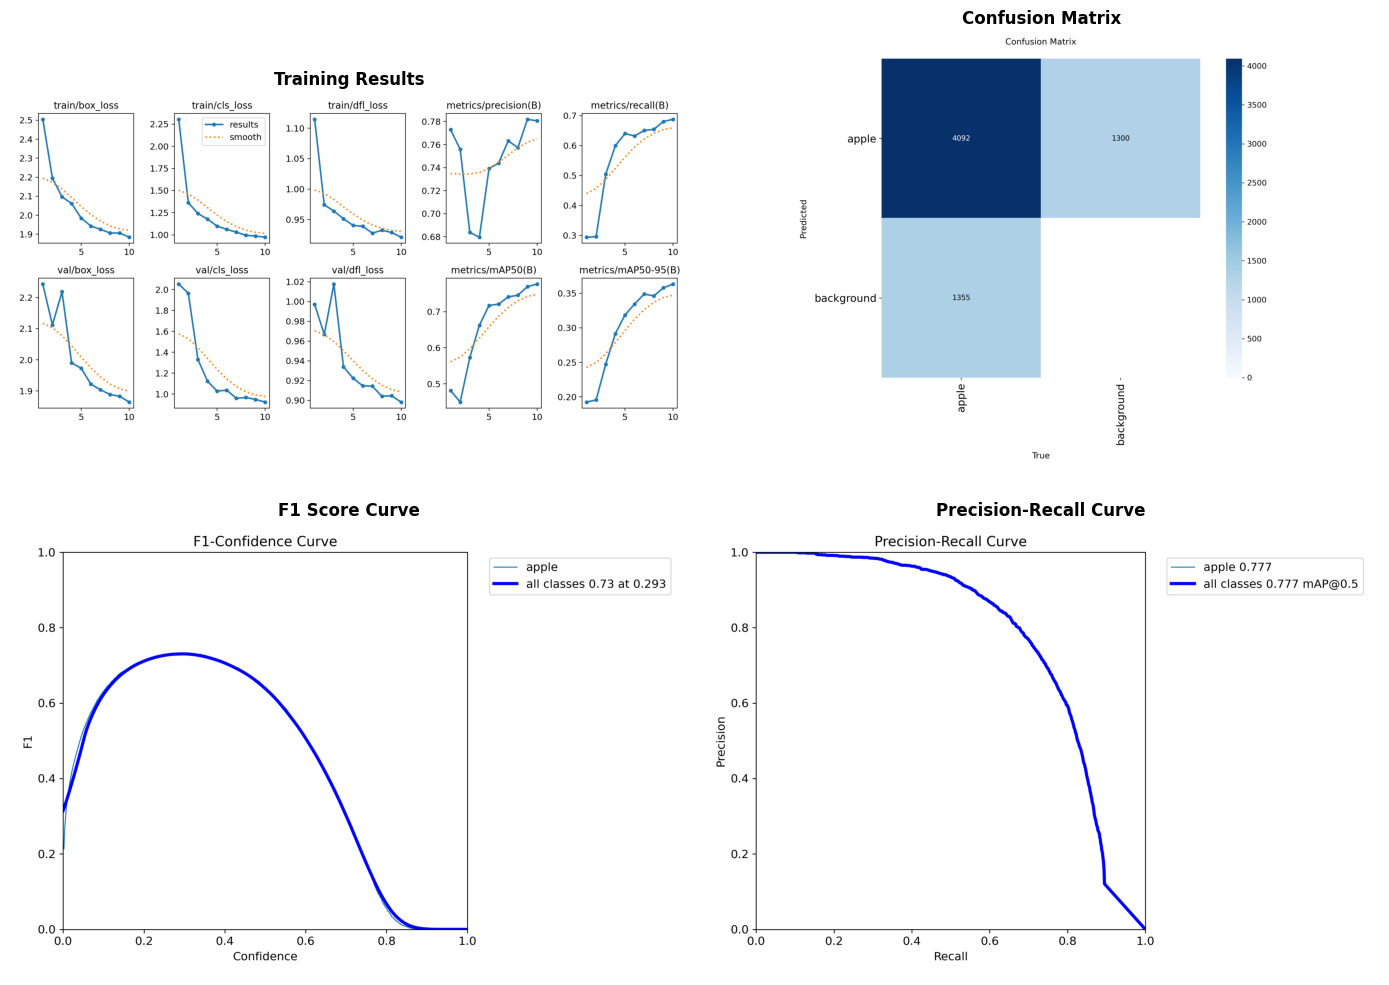

In [ ]:
# Display training results
results_dir = "runs/detect/apple_detection/yolov8n_apples"

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Load and display training plots
plot_files = ['results.png', 'confusion_matrix.png', 'BoxF1_curve.png', 'BoxPR_curve.png']
titles = ['Training Results', 'Confusion Matrix', 'F1 Score Curve', 'Precision-Recall Curve']

for ax, plot_file, title in zip(axes.flatten(), plot_files, titles):
    plot_path = f"{results_dir}/{plot_file}"
    if os.path.exists(plot_path):
        img = Image.open(plot_path)
        ax.imshow(img)
        ax.set_title(title, fontsize=12, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f'{plot_file}\nnot found', ha='center', va='center')
        ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

---

## Model Evaluation

Let's evaluate the trained model on the validation set and analyze the results in detail.

In [ ]:
# Load the best model
best_model_path = f"{results_dir}/weights/best.pt"
trained_model = YOLO(best_model_path)

# Evaluate on validation set
metrics = trained_model.val(data=data_yaml_path, verbose=True)

print("\n" + "="*50)
print("📊 EVALUATION RESULTS")
print("="*50)
print(f"mAP@0.5:      {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"Precision:    {metrics.box.mp:.4f}")
print(f"Recall:       {metrics.box.mr:.4f}")

Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5447.5±771.0 MB/s, size: 1417.7 KB)
val: Scanning /content/apple_yolo_dataset/labels/val.cache... 134 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 134/134 46.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 1.2s/it 11.2s
                   all        134       5447      0.781      0.688      0.777      0.363
Speed: 5.0ms preprocess, 7.5ms inference, 0.0ms loss, 11.7ms postprocess per image
Results saved to /content/runs/detect/val

📊 EVALUATION RESULTS
mAP@0.5:      0.7768
mAP@0.5:0.95: 0.3630
Precision:    0.7810
Recall:       0.6883


---

## Visual Analysis of Predictions

### Comparing Predictions vs Ground Truth

Let's visualize model predictions alongside ground truth to understand:
- Where the model succeeds
- Where it fails (missed detections, false positives)
- The quality of bounding box localization

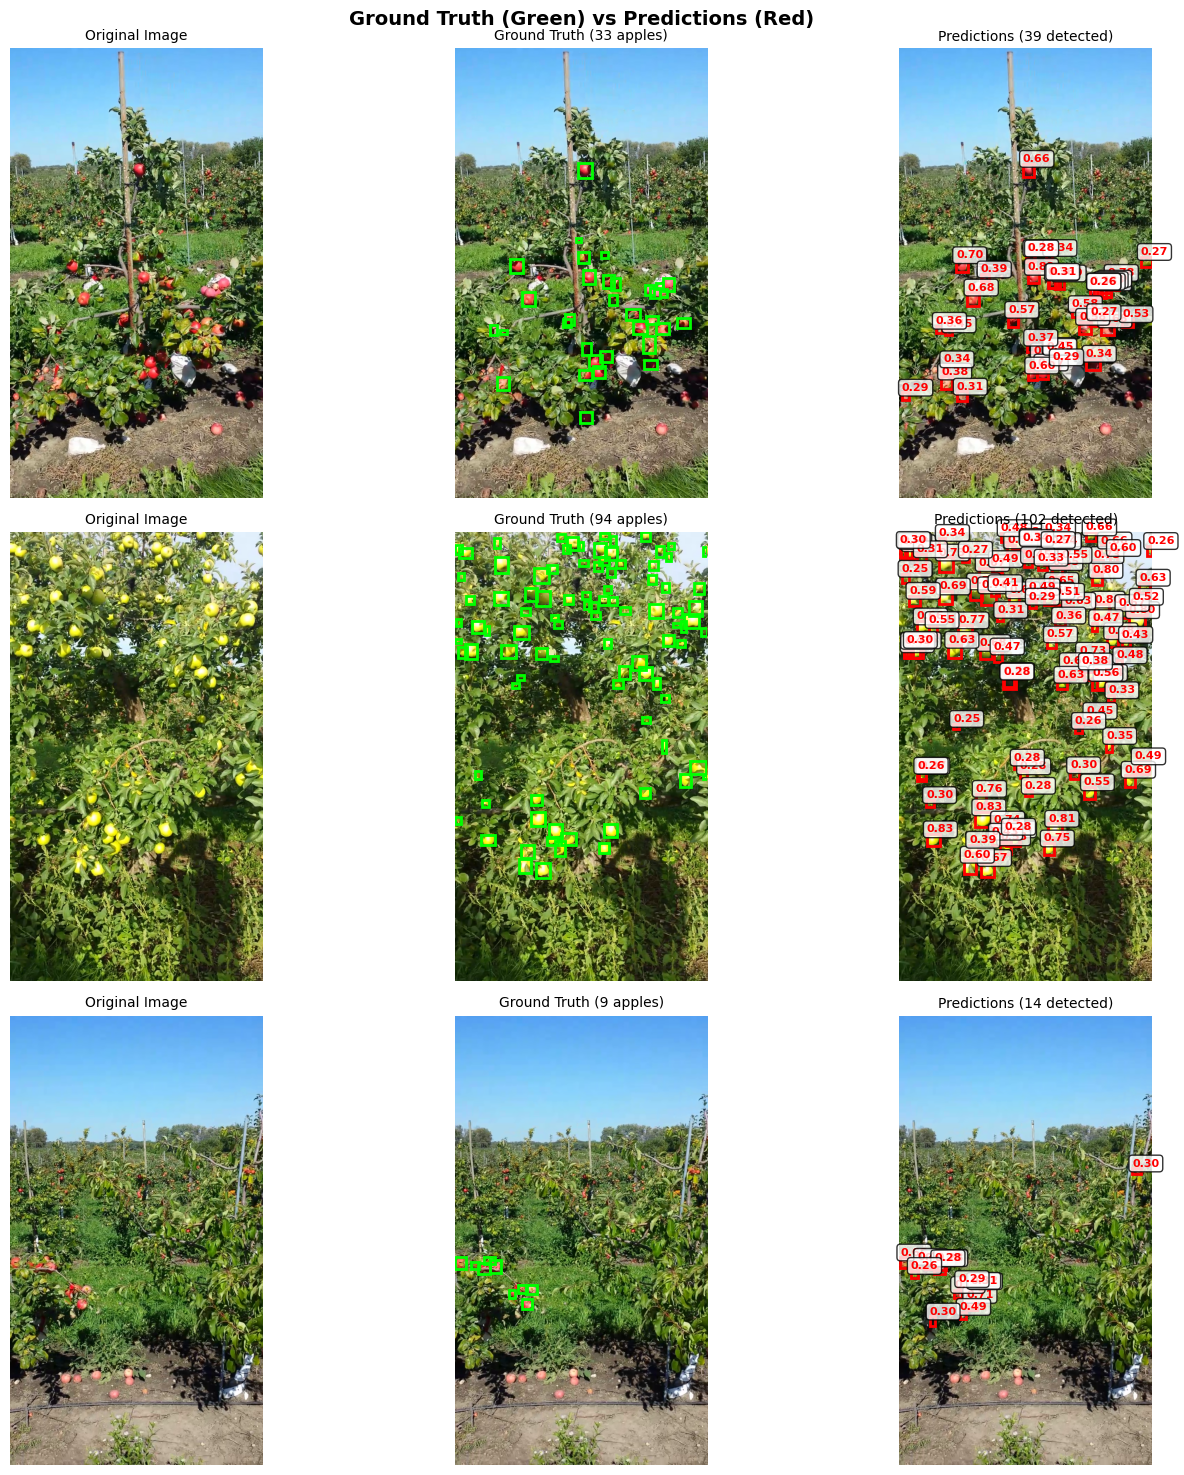

In [ ]:
def visualize_predictions(model, dataset, num_samples=6, conf_threshold=0.5):
    """Visualize model predictions vs ground truth."""

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    # Get random validation images
    val_images_dir = f"{yolo_dataset_path}/images/val"
    val_labels_dir = f"{yolo_dataset_path}/labels/val"
    val_images = os.listdir(val_images_dir)

    sample_images = random.sample(val_images, min(num_samples, len(val_images)))

    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(val_images_dir, img_name)
        label_path = os.path.join(val_labels_dir, img_name.replace('.png', '.txt').replace('.jpg', '.txt'))

        # Load image
        img = Image.open(img_path)
        img_np = np.array(img)
        h, w = img_np.shape[:2]

        # Load ground truth boxes
        gt_boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        _, x_center, y_center, bw, bh = map(float, parts[:5])
                        # Convert from YOLO format to pixel coordinates
                        xmin = (x_center - bw/2) * w
                        ymin = (y_center - bh/2) * h
                        xmax = (x_center + bw/2) * w
                        ymax = (y_center + bh/2) * h
                        gt_boxes.append([xmin, ymin, xmax, ymax])

        # Get predictions
        results = model.predict(img_path, conf=conf_threshold, verbose=False)
        pred_boxes = results[0].boxes.xyxy.cpu().numpy() if len(results[0].boxes) > 0 else []
        pred_confs = results[0].boxes.conf.cpu().numpy() if len(results[0].boxes) > 0 else []

        # Plot original image
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title(f'Original Image', fontsize=10)
        axes[i, 0].axis('off')

        # Plot ground truth
        axes[i, 1].imshow(img_np)
        for box in gt_boxes:
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                      linewidth=2, edgecolor='lime', facecolor='none')
            axes[i, 1].add_patch(rect)
        axes[i, 1].set_title(f'Ground Truth ({len(gt_boxes)} apples)', fontsize=10)
        axes[i, 1].axis('off')

        # Plot predictions
        axes[i, 2].imshow(img_np)
        for j, box in enumerate(pred_boxes):
            xmin, ymin, xmax, ymax = box
            conf = pred_confs[j] if j < len(pred_confs) else 0
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                      linewidth=2, edgecolor='red', facecolor='none')
            axes[i, 2].add_patch(rect)
            axes[i, 2].text(xmin, ymin-5, f'{conf:.2f}', color='red', fontsize=8,
                           fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        axes[i, 2].set_title(f'Predictions ({len(pred_boxes)} detected)', fontsize=10)
        axes[i, 2].axis('off')

    plt.suptitle('Ground Truth (Green) vs Predictions (Red)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(trained_model, ds, num_samples=3, conf_threshold=0.25)

### Confidence Threshold Analysis

The confidence threshold dramatically affects the precision-recall trade-off. Let's visualize how different thresholds affect detection results:

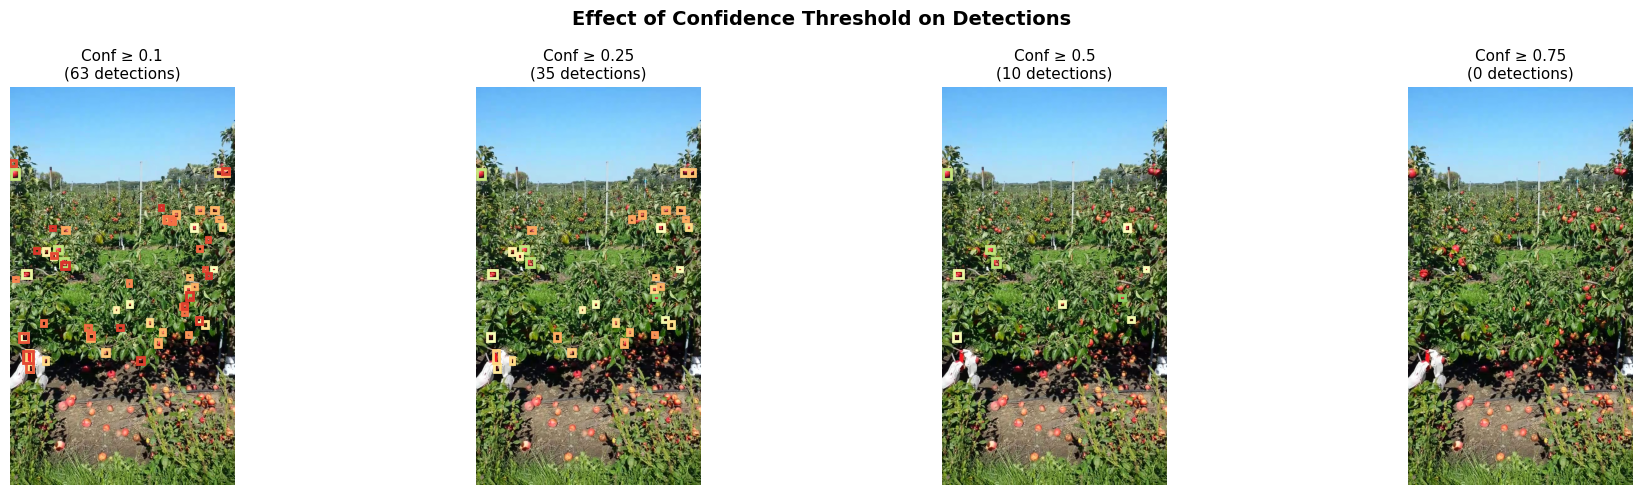

In [ ]:
def compare_confidence_thresholds(model, img_path, thresholds=[0.1, 0.25, 0.5, 0.75]):
    """Compare detection results at different confidence thresholds."""

    fig, axes = plt.subplots(1, len(thresholds), figsize=(5*len(thresholds), 5))
    img = Image.open(img_path)
    img_np = np.array(img)

    for ax, conf_thresh in zip(axes, thresholds):
        results = model.predict(img_path, conf=conf_thresh, verbose=False)
        pred_boxes = results[0].boxes.xyxy.cpu().numpy() if len(results[0].boxes) > 0 else []
        pred_confs = results[0].boxes.conf.cpu().numpy() if len(results[0].boxes) > 0 else []

        ax.imshow(img_np)
        for j, box in enumerate(pred_boxes):
            xmin, ymin, xmax, ymax = box
            conf = pred_confs[j]
            # Color based on confidence
            color = plt.cm.RdYlGn(conf)
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                      linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

        ax.set_title(f'Conf ≥ {conf_thresh}\n({len(pred_boxes)} detections)', fontsize=11)
        ax.axis('off')

    plt.suptitle('Effect of Confidence Threshold on Detections', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Pick a sample image
val_images_dir = f"{yolo_dataset_path}/images/val"
sample_img = os.path.join(val_images_dir, random.choice(os.listdir(val_images_dir)))
compare_confidence_thresholds(trained_model, sample_img)

### Detection Error Analysis

Let's analyze the types of errors the model makes:

In [ ]:
def compute_iou(box1, box2):
    """Compute IoU between two boxes [xmin, ymin, xmax, ymax]."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0

def analyze_errors(model, dataset_path, conf_threshold=0.5, iou_threshold=0.5):
    """Analyze detection errors: false positives, false negatives, and IoU distribution."""

    val_images_dir = f"{dataset_path}/images/val"
    val_labels_dir = f"{dataset_path}/labels/val"

    all_ious = []
    total_gt = 0
    total_pred = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for img_name in tqdm(os.listdir(val_images_dir), desc="Analyzing errors"):
        img_path = os.path.join(val_images_dir, img_name)
        label_path = os.path.join(val_labels_dir, img_name.replace('.png', '.txt').replace('.jpg', '.txt'))

        img = Image.open(img_path)
        h, w = np.array(img).shape[:2]

        # Load ground truth
        gt_boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        _, x_center, y_center, bw, bh = map(float, parts[:5])
                        xmin = (x_center - bw/2) * w
                        ymin = (y_center - bh/2) * h
                        xmax = (x_center + bw/2) * w
                        ymax = (y_center + bh/2) * h
                        gt_boxes.append([xmin, ymin, xmax, ymax])

        # Get predictions
        results = model.predict(img_path, conf=conf_threshold, verbose=False)
        pred_boxes = results[0].boxes.xyxy.cpu().numpy().tolist() if len(results[0].boxes) > 0 else []

        total_gt += len(gt_boxes)
        total_pred += len(pred_boxes)

        # Match predictions to ground truth
        matched_gt = set()
        for pred_box in pred_boxes:
            best_iou = 0
            best_gt_idx = -1
            for gt_idx, gt_box in enumerate(gt_boxes):
                if gt_idx not in matched_gt:
                    iou = compute_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = gt_idx

            if best_iou >= iou_threshold:
                true_positives += 1
                matched_gt.add(best_gt_idx)
                all_ious.append(best_iou)
            else:
                false_positives += 1

        false_negatives += len(gt_boxes) - len(matched_gt)

    # Calculate metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Error breakdown
    error_types = ['True Positives', 'False Positives', 'False Negatives']
    error_counts = [true_positives, false_positives, false_negatives]
    colors = ['#2ecc71', '#e74c3c', '#f39c12']

    bars = axes[0].bar(error_types, error_counts, color=colors, edgecolor='black')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Detection Error Breakdown')
    for bar, count in zip(bars, error_counts):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                    str(count), ha='center', va='bottom', fontweight='bold')

    # IoU distribution
    if all_ious:
        axes[1].hist(all_ious, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
        axes[1].axvline(np.mean(all_ious), color='red', linestyle='--', label=f'Mean: {np.mean(all_ious):.3f}')
        axes[1].set_xlabel('IoU')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('IoU Distribution (True Positives)')
        axes[1].legend()

    # Metrics summary
    metrics_names = ['Precision', 'Recall', 'F1-Score']
    metrics_values = [precision, recall, f1]
    bars = axes[2].bar(metrics_names, metrics_values, color=['#3498db', '#9b59b6', '#1abc9c'], edgecolor='black')
    axes[2].set_ylim(0, 1)
    axes[2].set_ylabel('Score')
    axes[2].set_title('Detection Metrics')
    for bar, val in zip(bars, metrics_values):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.suptitle(f'Error Analysis (conf={conf_threshold}, iou={iou_threshold})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"\n📊 Error Analysis Summary:")
    print(f"   Total ground truth objects: {total_gt}")
    print(f"   Total predictions: {total_pred}")
    print(f"   True Positives: {true_positives}")
    print(f"   False Positives: {false_positives}")
    print(f"   False Negatives: {false_negatives}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    if all_ious:
        print(f"   Mean IoU (TP): {np.mean(all_ious):.4f}")

# Run error analysis
analyze_errors(trained_model, yolo_dataset_path, conf_threshold=0.25)

NameError: name 'trained_model' is not defined

### Prediction Confidence Distribution

Let's analyze the distribution of confidence scores to understand model calibration:

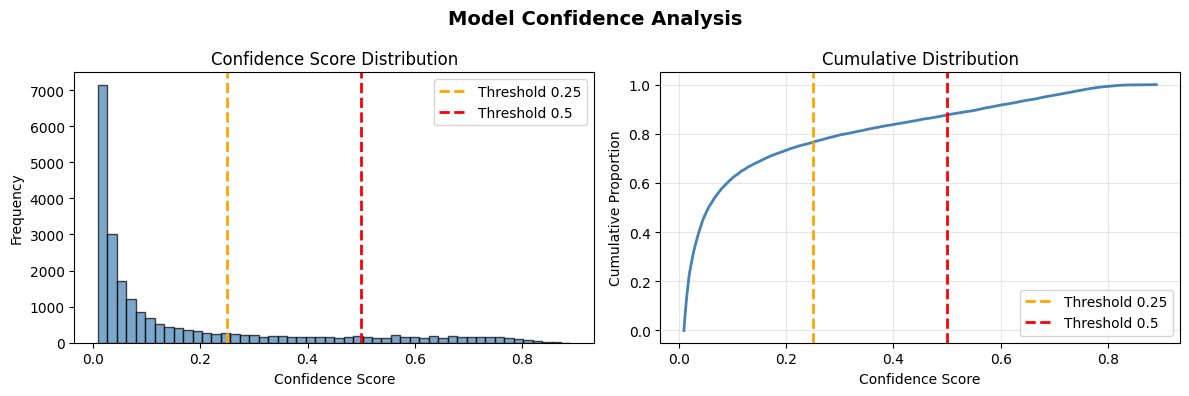


📊 Confidence Statistics:
   Total predictions (conf > 0.01): 22625
   Mean confidence: 0.1666
   Median confidence: 0.0560
   % above 0.25: 23.4%
   % above 0.5: 12.3%
   % above 0.75: 2.2%


In [ ]:
def analyze_confidence_distribution(model, dataset_path):
    """Analyze the distribution of confidence scores."""

    val_images_dir = f"{dataset_path}/images/val"
    all_confidences = []

    for img_name in tqdm(os.listdir(val_images_dir), desc="Collecting confidences"):
        img_path = os.path.join(val_images_dir, img_name)
        results = model.predict(img_path, conf=0.01, verbose=False)  # Very low threshold to get all

        if len(results[0].boxes) > 0:
            confs = results[0].boxes.conf.cpu().numpy()
            all_confidences.extend(confs)

    all_confidences = np.array(all_confidences)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram
    axes[0].hist(all_confidences, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(0.25, color='orange', linestyle='--', linewidth=2, label='Threshold 0.25')
    axes[0].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold 0.5')
    axes[0].set_xlabel('Confidence Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Confidence Score Distribution')
    axes[0].legend()

    # Cumulative distribution
    sorted_conf = np.sort(all_confidences)
    cumulative = np.arange(1, len(sorted_conf) + 1) / len(sorted_conf)
    axes[1].plot(sorted_conf, cumulative, color='steelblue', linewidth=2)
    axes[1].axvline(0.25, color='orange', linestyle='--', linewidth=2, label='Threshold 0.25')
    axes[1].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold 0.5')
    axes[1].set_xlabel('Confidence Score')
    axes[1].set_ylabel('Cumulative Proportion')
    axes[1].set_title('Cumulative Distribution')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle('Model Confidence Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Statistics
    print(f"\n📊 Confidence Statistics:")
    print(f"   Total predictions (conf > 0.01): {len(all_confidences)}")
    print(f"   Mean confidence: {np.mean(all_confidences):.4f}")
    print(f"   Median confidence: {np.median(all_confidences):.4f}")
    print(f"   % above 0.25: {100 * np.mean(all_confidences > 0.25):.1f}%")
    print(f"   % above 0.5: {100 * np.mean(all_confidences > 0.5):.1f}%")
    print(f"   % above 0.75: {100 * np.mean(all_confidences > 0.75):.1f}%")

analyze_confidence_distribution(trained_model, yolo_dataset_path)

---

## Inference Demo

Let's run inference on a few images and display results with confidence scores:

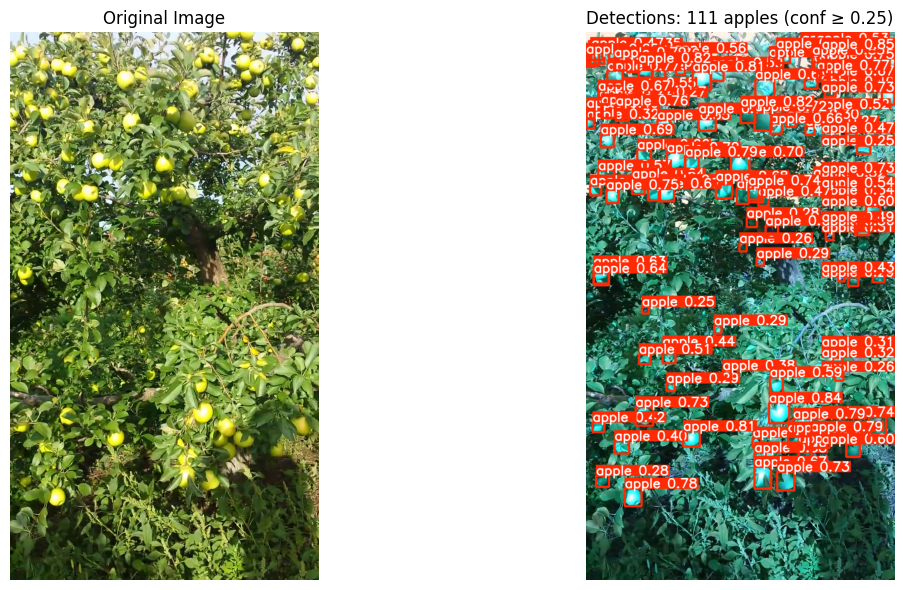


🍎 Detection Details:
   Apple 1: confidence = 0.850
   Apple 2: confidence = 0.845
   Apple 3: confidence = 0.837
   Apple 4: confidence = 0.822
   Apple 5: confidence = 0.818
   Apple 6: confidence = 0.812
   Apple 7: confidence = 0.809
   Apple 8: confidence = 0.794
   Apple 9: confidence = 0.790
   Apple 10: confidence = 0.789
   Apple 11: confidence = 0.785
   Apple 12: confidence = 0.781
   Apple 13: confidence = 0.771
   Apple 14: confidence = 0.765
   Apple 15: confidence = 0.764
   Apple 16: confidence = 0.757
   Apple 17: confidence = 0.756
   Apple 18: confidence = 0.751
   Apple 19: confidence = 0.749
   Apple 20: confidence = 0.744
   Apple 21: confidence = 0.744
   Apple 22: confidence = 0.735
   Apple 23: confidence = 0.734
   Apple 24: confidence = 0.726
   Apple 25: confidence = 0.726
   Apple 26: confidence = 0.722
   Apple 27: confidence = 0.719
   Apple 28: confidence = 0.701
   Apple 29: confidence = 0.698
   Apple 30: confidence = 0.689
   Apple 31: confidence = 0

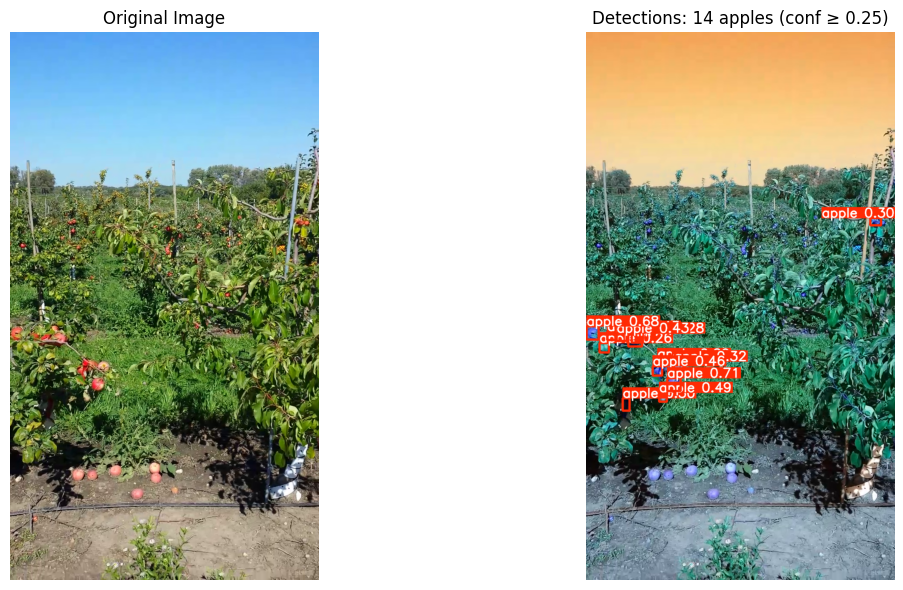


🍎 Detection Details:
   Apple 1: confidence = 0.714
   Apple 2: confidence = 0.678
   Apple 3: confidence = 0.495
   Apple 4: confidence = 0.465
   Apple 5: confidence = 0.429
   Apple 6: confidence = 0.428
   Apple 7: confidence = 0.319
   Apple 8: confidence = 0.311
   Apple 9: confidence = 0.302
   Apple 10: confidence = 0.296
   Apple 11: confidence = 0.289
   Apple 12: confidence = 0.278
   Apple 13: confidence = 0.277
   Apple 14: confidence = 0.258


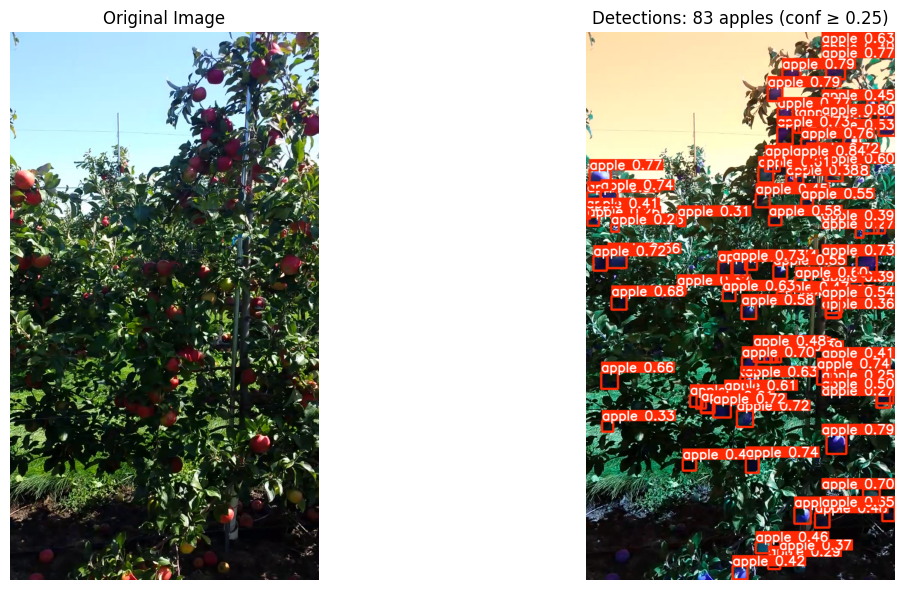


🍎 Detection Details:
   Apple 1: confidence = 0.842
   Apple 2: confidence = 0.801
   Apple 3: confidence = 0.793
   Apple 4: confidence = 0.793
   Apple 5: confidence = 0.788
   Apple 6: confidence = 0.771
   Apple 7: confidence = 0.768
   Apple 8: confidence = 0.766
   Apple 9: confidence = 0.756
   Apple 10: confidence = 0.746
   Apple 11: confidence = 0.744
   Apple 12: confidence = 0.737
   Apple 13: confidence = 0.737
   Apple 14: confidence = 0.732
   Apple 15: confidence = 0.727
   Apple 16: confidence = 0.726
   Apple 17: confidence = 0.722
   Apple 18: confidence = 0.717
   Apple 19: confidence = 0.717
   Apple 20: confidence = 0.716
   Apple 21: confidence = 0.703
   Apple 22: confidence = 0.699
   Apple 23: confidence = 0.680
   Apple 24: confidence = 0.665
   Apple 25: confidence = 0.649
   Apple 26: confidence = 0.633
   Apple 27: confidence = 0.633
   Apple 28: confidence = 0.627
   Apple 29: confidence = 0.626
   Apple 30: confidence = 0.613
   Apple 31: confidence = 0

In [ ]:
# Beautiful inference visualization
def display_detection_results(model, img_path, conf_threshold=0.25):
    """Display detection results with a clean visualization."""

    results = model.predict(img_path, conf=conf_threshold, verbose=False)

    # Get annotated image from YOLO
    annotated = results[0].plot()

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Original
    img = Image.open(img_path)
    axes[0].imshow(img)
    axes[0].set_title('Original Image', fontsize=12)
    axes[0].axis('off')

    # With detections
    axes[1].imshow(annotated)
    n_detections = len(results[0].boxes)
    axes[1].set_title(f'Detections: {n_detections} apples (conf ≥ {conf_threshold})', fontsize=12)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # Print detection details
    if n_detections > 0:
        print(f"\n🍎 Detection Details:")
        confs = results[0].boxes.conf.cpu().numpy()
        for i, conf in enumerate(confs):
            print(f"   Apple {i+1}: confidence = {conf:.3f}")

# Demo on random validation images
val_images_dir = f"{yolo_dataset_path}/images/val"
demo_images = random.sample(os.listdir(val_images_dir), 3)

for img_name in demo_images:
    display_detection_results(trained_model, os.path.join(val_images_dir, img_name))

---

## Summary

### What We Learned

| Concept | Description |
|---------|-------------|
| **Object Detection** | Localize + classify multiple objects in an image |
| **Bounding Boxes** | Rectangle coordinates defining object location |
| **IoU** | Intersection over Union - measures box overlap |
| **NMS** | Non-Maximum Suppression - removes duplicate detections |
| **mAP** | Mean Average Precision - standard detection metric |
| **YOLO** | Real-time one-stage detector |

### Detection Pipeline

```
Image → Backbone (features) → Neck (multi-scale fusion) → Head (predictions) → NMS → Final Detections
```

### Key Takeaways

1. **One-stage detectors** (YOLO) are fast and suitable for real-time applications
2. **Confidence threshold** controls precision-recall trade-off
3. **IoU threshold** determines what counts as a "correct" detection
4. **Data format** matters - YOLO uses normalized center-format coordinates
5. **Transfer learning** from COCO significantly speeds up training

### Comparison: Classification vs Segmentation vs Detection

| Aspect | Classification | Segmentation | Detection |
|--------|---------------|--------------|-----------|
| Output | Single label | Pixel mask | Boxes + labels |
| Objects | One per image | All pixels | Multiple boxes |
| Location | No | Pixel-level | Box-level |
| Loss | Cross-entropy | Dice/BCE | Box + Class loss |

### Potential Improvements

- **Data augmentation**: Mosaic, mixup, random crop
- **Larger models**: YOLOv8s/m for better accuracy
- **Longer training**: More epochs with learning rate scheduling
- **Hyperparameter tuning**: Confidence threshold, NMS IoU threshold
- **Post-processing**: Weighted boxes fusion for ensemble models

### Other Detection Architectures

| Architecture | Type | Key Feature |
|--------------|------|-------------|
| **Faster R-CNN** | Two-stage | Region Proposal Network |
| **SSD** | One-stage | Multi-scale feature maps |
| **RetinaNet** | One-stage | Focal Loss for class imbalance |
| **YOLO** | One-stage | End-to-end, fast inference |
| **DETR** | Transformer | No NMS, set prediction |
| **RT-DETR** | Transformer | Real-time DETR variant |

---

# Questions

### Question 1 : Différence entre Classification, Segmentation et Détection

**Quelle est la principale différence entre les tâches de classification, segmentation et détection d'objets ?**

Donnez un exemple concret d'application pour chacune de ces tâches.

Réponse:

---

### Question 2 : Base de données

**Décrivez les données en quelques lignes. Combien d'images y a t'il dans la base de données ? Que représentent les images ? Quel est l'objectif de ce jeu de données ?**


Réponse:


---

### Question 3 : YOLO

**Décrivez en une phrase l'architecture YOLO.**


Réponse:


### Question 4 : Seuil de confiance

**Lancer le code ci-dessous et observer les performances du modèle lorsque l'on change le seuil de score de confiance.**


In [ ]:
def evaluate_at_confidence_thresholds(model, dataset_path, thresholds=[0.1, 0.25, 0.5, 0.75, 0.9]):
    """Évalue le modèle à différents seuils de confiance."""

    results_table = []

    for conf_thresh in thresholds:
        # Validation avec ce seuil
        results = model.val(
            data=f"{dataset_path}/data.yaml",
            conf=conf_thresh,
            verbose=False
        )

        # Extraire les métriques
        precision = results.box.mp  # Mean Precision
        recall = results.box.mr     # Mean Recall
        map50 = results.box.map50   # mAP@0.5

        results_table.append({
            'Seuil Confiance': conf_thresh,
            'Précision': f"{precision:.4f}",
            'Rappel': f"{recall:.4f}",
            'mAP@0.5': f"{map50:.4f}"
        })
        print(f"Conf={conf_thresh:.2f} → Précision={precision:.4f}, Rappel={recall:.4f}, mAP@0.5={map50:.4f}")

    return results_table

thresholds = [0.1, 0.25, 0.5, 0.75, 0.9]
results = evaluate_at_confidence_thresholds(trained_model, yolo_dataset_path, thresholds)

**Comment évoluent les métriques (Précision/Rappel/mAP@0.5) en fonction du seuil du confiance ? Finalement, lequel choisiriez vous, et pourquoi ?**

Réponse:

---

### Question 5 : Nouveau Modèle
**Relancer l'entrainement de votre modèle YOLO en changeant les hyperparamètres (Learning Rate, Taille des images, Batch Size, Taille du modèle...) et notez les résultats. Votre nouveau modèle est-il meilleur que l'ancien ? Quel est le problème du dataset ? Quel genre d'image pose le plus de problème ?**



| Modèle | Taille images | Époques | Batch size | Learning rate | mAP@0.5 | mAP@0.5:0.95 |
|--------|---------------|---------|------------|---------------|---------|--------------|
|YOLOv8n |640            |10       |            |               |         |              |
|        |               |         |            |               |         |              |
|        |               |         |            |               |         |              |
|        |               |         |            |               |         |              |
